In [494]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import precision_score, recall_score
import time
import warnings

In [495]:
data_cleaned = pd.read_csv('cleaned_data_w_uids.csv', low_memory=False, index_col=[0])
data_officers_fulldf = pd.read_csv('officers_only_fulldf.csv', low_memory=False, index_col=[0])

data_cleaned = data_cleaned.rename(columns={'y': 'disciplined'})

# data_cleaned = data_cleaned[data_cleaned['sustained'] == 1]

# data_cleaned = data_cleaned[data_cleaned['disciplined'] == 1]

In [496]:

# halve all index values
data_cleaned.index = data_officers_fulldf.index

In [497]:
# merge, but if the columns are the same, keep the ones from the clean data
merged = data_officers_fulldf.merge(data_cleaned, how='outer', left_index=True, right_index=True, validate='1:1', suffixes=('_off', ''))
merged = merged.loc[:, ~merged.columns.str.endswith('_off')]

In [498]:
merged.drop(['UID'], axis=1, inplace=True)

In [499]:
# merged = merged[merged['sustained'] == 1]

In [500]:
data_cleaned = merged

## Data Transformations

In [501]:
# data_cleaned.corr()['sustained'].sort_values(ascending=False)

# Sustained shouldn't be a predictor
data_cleaned.drop('sustained', axis=1, inplace=True)

# Add some noise to salary
data_cleaned['salary'] = (data_cleaned['salary'] + np.random.normal(0,5,data_cleaned.shape[0]))
# Add some noise to age
data_cleaned['officer_age'] = data_cleaned['officer_age'] + np.random.normal(0,1.5,data_cleaned.shape[0])

In [502]:
# What percentage of complaints are disciplined?
data_cleaned['disciplined'].value_counts(normalize=True)

0    0.955636
1    0.044364
Name: disciplined, dtype: float64

In [503]:
# Only include columns with correlation >0.005 with disciplined (quick and dirty but theres a LOT of columns so)
# data_cleaned = data_cleaned[data_cleaned.columns[data_cleaned.corr()['disciplined'].abs() > 0.005]]

In [504]:
# Split the data into features (X) and target (y)
X = data_cleaned.drop('disciplined', axis=1)
y = data_cleaned['disciplined']

# add intercept
# X = sm.add_constant(X)

# Remove all perfect correlations with other variables
# X = X.loc[:,~X.columns.duplicated()]

In [505]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# combine X_train_resampled and y_train_resampled into a dataframe
# X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)

In [506]:
# Drop singular matrix columns
sing_matrix = []
for col in X_train.columns:
    if X_train[col].nunique() == 1:
        sing_matrix.append(col)

X_train.drop(sing_matrix, axis=1, inplace=True)
X_test.drop(sing_matrix, axis=1, inplace=True)

In [507]:
# Calculate VIF for each feature
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Remove features from X_train and X_test with VIF > 5
vif['features'] = X_train.columns
vif = vif[vif['VIF Factor'] > 20]

X_train.drop(vif['features'], axis=1, inplace=True)
X_test.drop(vif['features'], axis=1, inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [508]:
X_test = sm.add_constant(X_test)

In [509]:
# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [510]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    # print("Predictors:", predictor_subset)
    # print("Y:", y_train_resampled)
    # print("X:", X_train_resampled[predictor_subset])
    # always include intercept
    # predictor_subset = predictor_subset + ['const']
    with_intercept = pd.DataFrame(sm.add_constant(X_train_resampled[predictor_subset]))

    model = sm.Logit(y_train_resampled, with_intercept).fit(disp=False)
    # max recall
    # model = sm.Logit(y_train_resampled, X_train_resampled).fit(disp=False, method='newton')
    score = model.aic
    return {"model":model, "score":score}

#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(pred):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train_resampled.columns if p not in pred]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(pred+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lower AIC
    best_model = models.loc[models['score'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(pred)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def forward_selection():
    models_best = pd.DataFrame(columns=["score", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X_train_resampled.columns)+1):
        print("Progress:", i, "/", len(X_train_resampled.columns))
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

models_best = forward_selection()

Progress: 1 / 18
Processed  18 models on 1 predictors in 0.9633638858795166 seconds.
Progress: 2 / 18
Processed  17 models on 2 predictors in 1.1749329566955566 seconds.
Progress: 3 / 18
Processed  16 models on 3 predictors in 1.2805581092834473 seconds.
Progress: 4 / 18
Processed  15 models on 4 predictors in 1.3627331256866455 seconds.
Progress: 5 / 18
Processed  14 models on 5 predictors in 1.4811320304870605 seconds.
Progress: 6 / 18
Processed  13 models on 6 predictors in 1.5036442279815674 seconds.
Progress: 7 / 18
Processed  12 models on 7 predictors in 1.4389598369598389 seconds.
Progress: 8 / 18
Processed  11 models on 8 predictors in 1.4497158527374268 seconds.
Progress: 9 / 18
Processed  10 models on 9 predictors in 1.3952560424804688 seconds.
Progress: 10 / 18
Processed  9 models on 10 predictors in 1.554682731628418 seconds.
Progress: 11 / 18
Processed  8 models on 11 predictors in 1.3651702404022217 seconds.
Progress: 12 / 18
Processed  7 models on 12 predictors in 1.3434

In [511]:
models_best['score'] = models_best['score'].astype(float)
models_best.sort_values(by='score', ascending=True, inplace=True)
best_model = models_best.iloc[0]['model']

best_model_params = best_model.params.index.tolist()
# X_train = X_train[best_model_params]
X_test = X_test[best_model_params]

In [512]:
def plot_confusion_matrix(y_test, y_pred):
    # Confusion matrix plot (percentages) multiplot of each model

    plt.figure(figsize=(20, 10))
    

    plt.subplot(1, 2, 1)

    cm = confusion_matrix(y_test, y_pred)
    # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.title('Model')
    plt.xlabel('Predicted (Num)')
    plt.ylabel('Actual (Num)')

    # plt.show()

    plt.subplot(1, 2, 2)

    # cm = confusion_matrix(y_test, y_pred)
    # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # sum across all elements and divide by total number of elements
    cm = cm.astype('float') / cm.sum()
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.title('Model')
    plt.xlabel('Predicted %')
    plt.ylabel('Actual %')

    # plt.show()


    print('Precision of the model: ', precision_score(y_test, y_pred))
    print('Recall of the model: ', recall_score(y_test, y_pred))

def test_and_graph_model(model, x_test, y_test):
    # Test the model
    y_pred = model.predict(x_test)

    # Check the accuracy of the model
    y_pred = np.where(y_pred > threshold, 1, 0)
    print('Accuracy of the model: ', (y_pred == y_test).mean())

    plot_confusion_matrix(y_test, y_pred)

In [513]:
import numpy as np
from sklearn.metrics import precision_recall_curve

X_train['const'] = 1

def find_best_threshold_max_recall(model, X_test, y_test, min_precision=0.5):
    y_pred_probs = model.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)
    
    # Find indices where precision is greater than or equal to the minimum acceptable precision
    acceptable_precision_indices = np.where(precision[:-1] >= min_precision)
    
    # Select the corresponding recall and threshold values
    acceptable_recall = recall[acceptable_precision_indices]
    acceptable_thresholds = thresholds[acceptable_precision_indices]
    
    # Find the index of the maximum recall value
    max_recall_index = np.argmax(acceptable_recall)
    
    # Find the best threshold value
    best_threshold = acceptable_thresholds[max_recall_index]

    return best_threshold

min_precision = 0.1 # Adjust this value based on your minimum acceptable precision
best_threshold_max_recall = find_best_threshold_max_recall(best_model, X_test, y_test, min_precision)
print("Best threshold value for maximizing recall while maintaining a minimum precision of", min_precision, ":", best_threshold_max_recall)

Best threshold value for maximizing recall while maintaining a minimum precision of 0.1 : 0.6646347209385559


Accuracy of the model:  0.9447062762368333
Precision of the model:  0.1661764705882353
Recall of the model:  0.06674542232722977


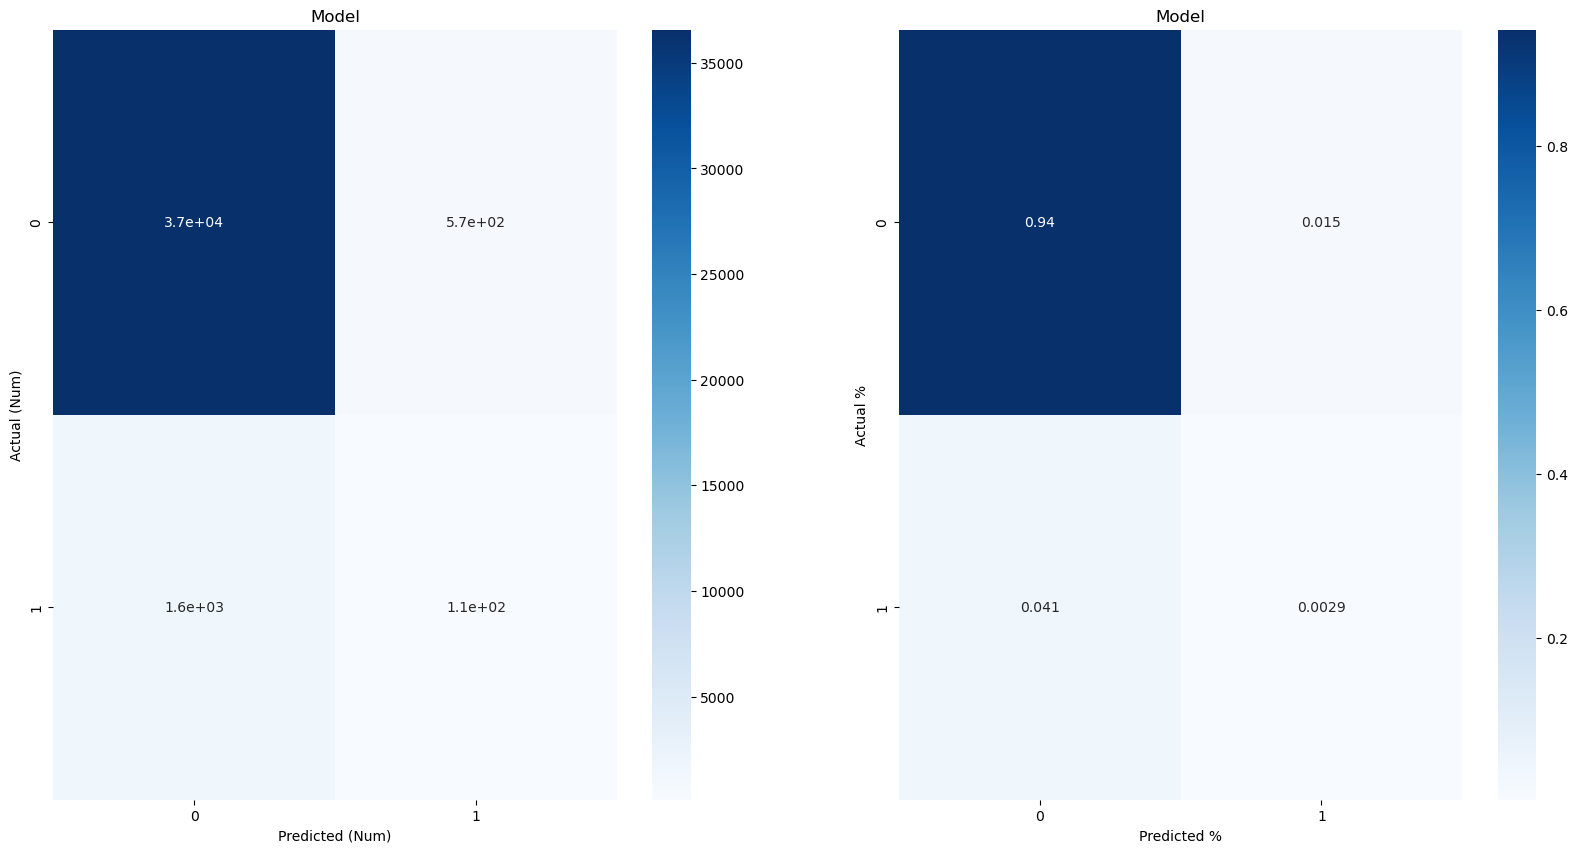

In [514]:
# accuracy of the model
threshold = best_threshold_max_recall
test_and_graph_model(best_model, X_test, y_test)

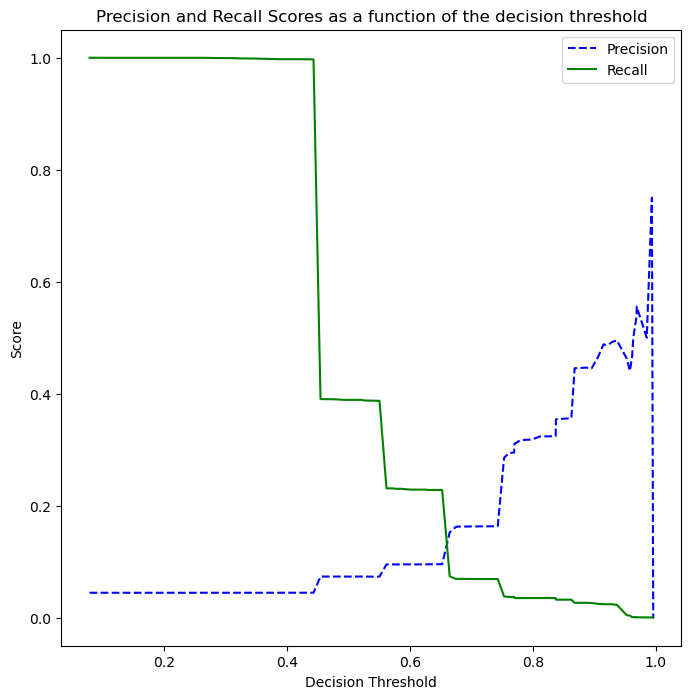

In [515]:
from sklearn.metrics import precision_recall_curve
ypred = best_model.predict(X_train[best_model_params])
p, r, thresholds = precision_recall_curve(y_train, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


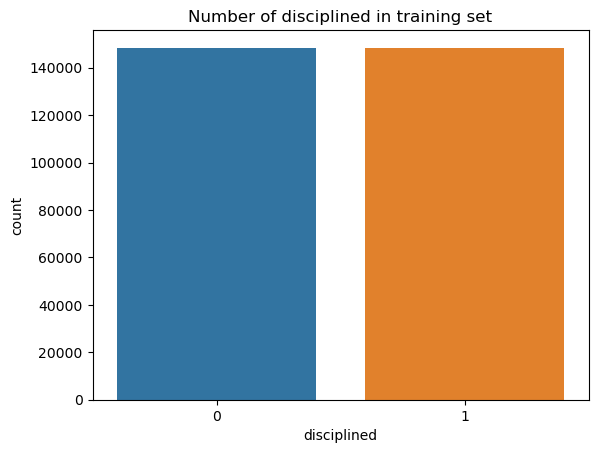

In [516]:
# Bar graph of how many 'disciplined' in training set
sns.countplot(y_train_resampled)
plt.title('Number of disciplined in training set')
plt.show()